# Predicting Rain in Seattle

This notebook aims to predict a classic classification problem regarding whether or not it will rain in Seattle using both logistic regression and k-nearest neighbors model. The data is available at the [National Oceanic and Atmospheric Administration (NOAA) website](https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND%3aUSW00024233/detail). There are 70 years worth of data, so it should be enough for building our models.  

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

## Data Cleaning
To prep our data for analysis, we will read the data and drop any rows with null values. Then we will extract values from both Date and PRCP column to create two new columns: Rain and Month. The Rain column will be in binary to make training our model a little easier. 

In [2]:
df = pd.read_csv("data/seattle_rain.csv")
df.dropna(how='any', inplace=True)
df.head(10)

,STATION,DATE,PRCP,TMAX,TMIN
0,USW00024233,1948-12-01,0.78,46,38
1,USW00024233,1948-12-02,0.00,44,34
2,USW00024233,1948-12-03,0.01,41,31
3,USW00024233,1948-12-04,0.11,39,30
4,USW00024233,1948-12-05,0.35,41,33
5,USW00024233,1948-12-06,0.25,42,36
6,USW00024233,1948-12-07,0.29,39,35
7,USW00024233,1948-12-08,0.39,38,32
8,USW00024233,1948-12-09,0.84,45,34
9,USW00024233,1948-12-10,0.16,46,39


In [3]:
#returns binary: 1 if True and 0 if False
df['RAIN'] = df['PRCP'].map(lambda x: 1 if x > 0.00 else 0)
#create month column by extracting the month from date column
df['MONTH'] = pd.DatetimeIndex(df['DATE']).month
#filter dataframe 
precip = df[df['RAIN'] == True]
dry = df[df['RAIN'] == False]

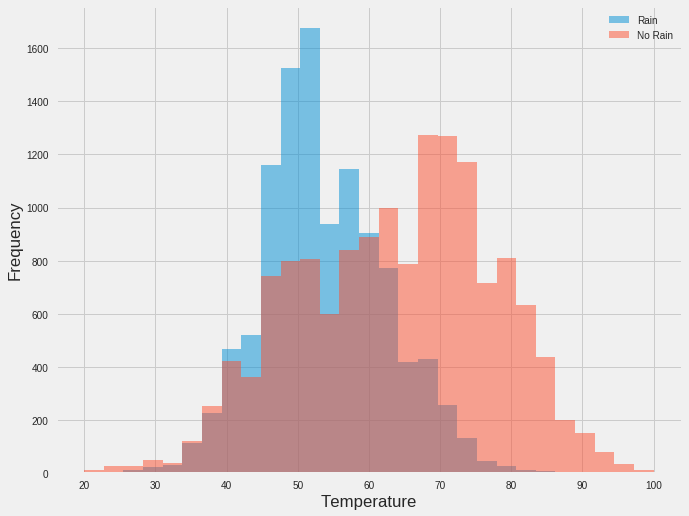

In [41]:
#visualize results on TMAX column
plt.style.use('fivethirtyeight')
bins = np.linspace(20,100,30)
plt.figure(figsize=(10,8))
plt.hist(precip['TMAX'], bins, alpha=0.5, label='Rain')
plt.hist(dry['TMAX'], bins, alpha=0.5, label='No Rain')
plt.legend(loc="upper right")
plt.xlabel('Temperature')
plt.ylabel('Frequency')

It appears that rain frequently occurs within temperatures between 40 to 64 degrees, and higher temperatures are associated with no precipitation. It seems most of the precipitation Seattle experiences is during the winter months. Let's check to see if our suspicions are correct.

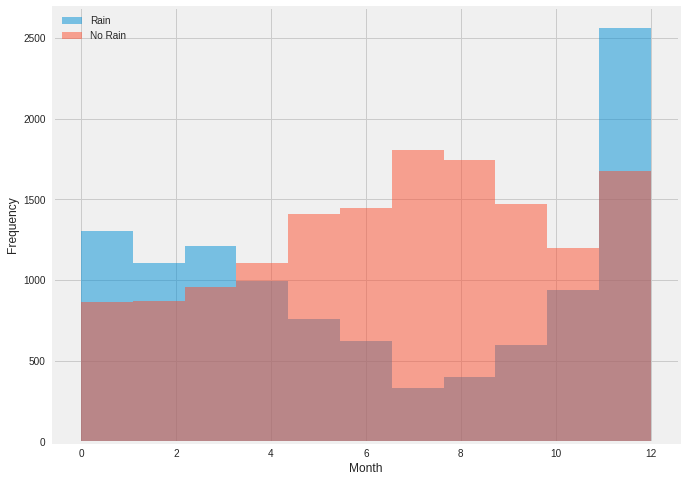

In [6]:
#visualize the results on month column
bins = np.linspace(0,12,12)
plt.figure(figsize=(10,8))
plt.hist(precip['MONTH'], bins, alpha=0.5, label='Rain')
plt.hist(dry['MONTH'], bins, alpha=0.5, label='No Rain')
plt.legend(loc="upper left")
plt.xlabel('Month')
plt.ylabel('Frequency')

We can expect precipitation in Seattle between November to March. Rain is less frequent during the spring and summer months; however, it picks up again at the start of October.

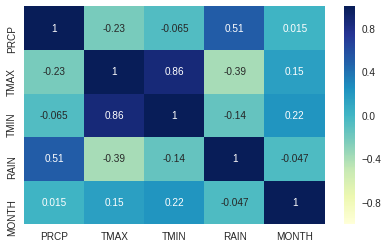

In [7]:
#any correlations between RAIN and the rest of the variables?
sns.heatmap(df.corr(), annot=True, cmap='YlGnBu')

PRCP correlates moderately with RAIN while the rest of the variables do not correlate with RAIN. Let's move on to predicting precipitation with some classification metrics. 

## Classification Metrics

In [19]:
#establish variables for train_test_split
cols = ['TMAX', 'TMIN', 'MONTH', 'PRCP']
X = df[cols]
y = df['RAIN']

from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Logistic Regression
Logistic Regression is used to conduct a dichotomous dependent variable. Since it is a predictive analysis, logistic regression is used to outline data and explain the relationship between one dependent binary variable and one or more independent variables. 

In [21]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(X,y)
y_pred = clf.predict(X)
accuracy = accuracy_score(y, y_pred)
print('Logistic Regression accuracy: {:.2f}'.format(accuracy))

Logistic Regression accuracy: 0.93


### Accuracy
The accuracy of the logistic regression model is nothing more than having a constant ratio to another quality of predictions that are made correctly. Our regression model was accurate ~93% of the time; however, it does not tell us *where* the model is making errors. We will use the confusion matrix to see the false positives and negatives within our model.

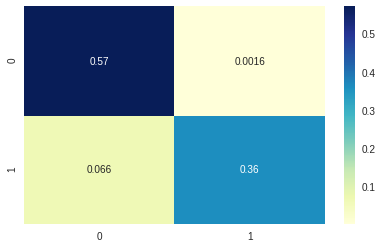

In [22]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y, y_pred) / len(y), annot=True, cmap='YlGnBu')

Our model predicted that rain occurred in 57% in all cases; for example, it predicted that it will rain and it did. The true negative rate is 36%; that is, the model predicted that it would not rain and it did not.

### K-Nearest Neighbors
K-Nearest Neighbors is an algorithm that stores every available case and classifies new ones on similarity distance functions (e.g., Euclidean Distance). The purpose behind the algorithm is to find a number of training samples closest in distance to a new point. If K = 1, then the algorithm assigns the class to its nearest neighbor. 

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X,y)
y_pred = knn.predict(X)
accuracy = accuracy_score(y, y_pred)
print('KNN accuracy: {:.2f}'.format(accuracy))

KNN accuracy: 0.90


Our model returned a ~90% accuracy. It is a slightly lower score compared to the logistic regression model. We can measure the relevancy and how many truly relevant results returned in our model by using the precision-recall method. In math:

$$\text{Precision} = \frac{\text{True Positives}}{\text{True Positives + False Positives}}$$

$$\text{Recall} = \frac{\text{True Positives}}{\text{True Positives + False Negatives}}$$

In [28]:
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
print('KNN Precision Score: {:.2f}'.format(precision_score(y, y_pred, average='binary')))
print('KNN Recall Score: {:.2f}'.format(recall_score(y, y_pred, average='binary')))

KNN Precision Score: 0.93
KNN Recall Score: 0.83


A high precision and recall rate indicates a good model. In our case, the precision and recall score for our model is ~93% and ~83% respesctivly. Although both precision and recall returned great scores, let's measure the potential trade-offs between them.  

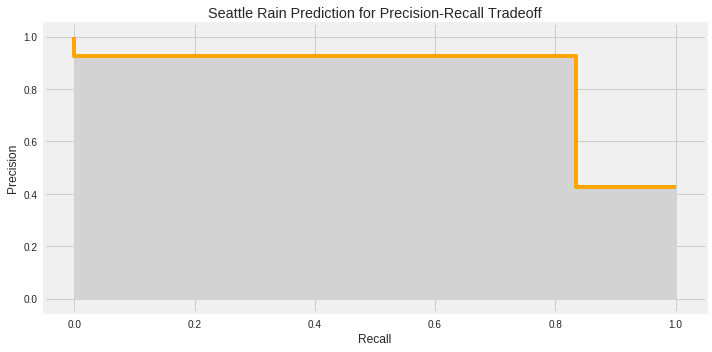

In [36]:
precision, recall, threshold = precision_recall_curve(y, y_pred)
plt.figure(figsize=(10,5))
plt.step(recall, precision, color='orange', where='post')
plt.fill_between(recall, precision, step='post', color='lightgray')
plt.title('Seattle Rain Prediction for Precision-Recall Tradeoff')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.tight_layout()

The trade-off between precision and recall is usually encoded using the F1-Score. The F1-score is a fit statistic that optimally blends both precision and recall; it is weighted by a harmonic mean to punish the most extreme values. In summary, the F1-score gives equal weights to both metrics where $\beta$ *hyperparameter* can be used to provide more weight to precision or recall.

### ROC Curve
We can use the Receiver Operator Characteristic (ROC) curve to show another visualization of the performance of a classification model. The ROC curve plots the model performance on two measures: true positive rate and false positive rate.

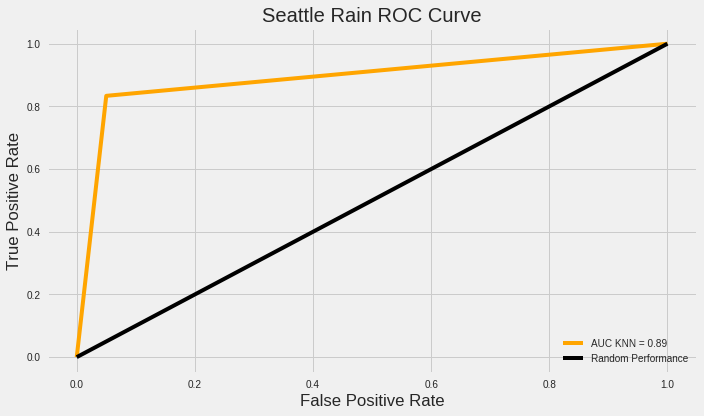

In [44]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y, y_pred)
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, color='orange', label='AUC KNN = {:.2f}'.format(auc(fpr, tpr)))
plt.plot([0,1],[0,1], color='black', label='Random Performance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Seattle Rain ROC Curve')
plt.legend(loc='lower right')
plt.tight_layout()

## Conclusion

Rain occurrence increases during the fall and winter months and decreases in the spring and summer months. The logistic regression model performed the best with an accuracy of 93% while the k-nearest neighbor had an accuracy of 90%. Both models have high efficiency in predictions of rain occurrence within a 70-year period. 